# Mouse Erythroid

This notebook will show you the basic usage of UniTVelo.\
In this tutorial, we will use the mouse gastrulation subset to erythroid lineage as example.\
Similar process can be applied on your own data or please refer to other [tutorials](https://github.com/StatBiomed/UniTVelo/tree/main/notebooks).

## Import Packages
Some of the pre- or post-processing steps for scRNA-seq data require functions from scVelo.\
Fot the time being, both scVelo and UniTVelo are imported.

In [31]:
import scvelo as scv
scv.settings.verbosity = 0
import unitvelo as utv

In [2]:
adata = scv.datasets.gastrulation_erythroid()
adata

AnnData object with n_obs × n_vars = 9815 × 53801
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm'
    uns: 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'

Here we define some basic parameters needed for the method,
- `dataset`: abosolute or relative path to the dataset (loom, h5ad, ...)
- `label`: name of the annotation column of observations in `adata.obs`
- `exp_metrics`: to store the evaluation results, default {}

In [3]:
dataset = './data/Gastrulation/erythroid_lineage.h5ad'
label = 'celltype'
exp_metrics = {}

Parameter `cluster_edges` is for algorithm evaluation purpose given expert annotated ground truth.\
It contains a list of tuples in which stores the source cluster and target cluster of cells.

In [4]:
cluster_edges = [
    ("Blood progenitors 1", "Blood progenitors 2"), 
    ("Blood progenitors 2", "Erythroid1"),
    ("Erythroid1", "Erythroid2"), 
    ("Erythroid2", "Erythroid3")]

## scVelo stochastic

For the following sections, we will comapre the model performance with both co-variance based stochastic mode and likelihood based dynamical mode.

  0%|          | 0/9815 [00:00<?, ?cells/s]

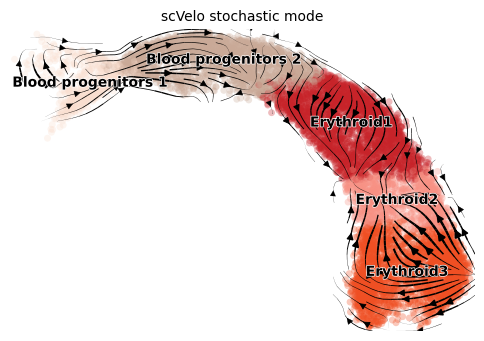

In [5]:
title = 'scVelo stochastic mode'
adata = scv.datasets.gastrulation_erythroid()
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

scv.tl.velocity(adata, mode='stochastic')

scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, color=label, dpi=100, title=title)

Model performance can be measured with two quantitative metrics beside visual inspection:
- Cross-Boundary Direction Correctness (A -> B): transition correctness between clusters
- In-Cluster Coherence: transition smoothness within clusters

In [7]:
scv.pp.neighbors(adata)
adata_velo = adata[:, adata.var.loc[adata.var['velocity_genes'] == True].index]
exp_metrics["model_sto"] = utv.evaluate(adata_velo, cluster_edges, label, 'velocity')

# Cross-Boundary Direction Correctness (A->B)
{('Blood progenitors 1', 'Blood progenitors 2'): 0.5155429131874362, ('Blood progenitors 2', 'Erythroid1'): 0.2579814031216949, ('Erythroid1', 'Erythroid2'): 0.32298710704390915, ('Erythroid2', 'Erythroid3'): -0.49925458479887247}
Total Mean: 0.14931420963854192
# In-cluster Coherence
{'Blood progenitors 1': 0.746955, 'Blood progenitors 2': 0.64198303, 'Erythroid1': 0.709536, 'Erythroid2': 0.67009205, 'Erythroid3': 0.93389046}
Total Mean: 0.7404912710189819


## scVelo dynamic

Dynamical mode tries to infer full transcriptional dynamics using a generalized mode.\
It also yields latent time and other subtle cellular processes.

  0%|          | 0/590 [00:00<?, ?gene/s]

  0%|          | 0/9815 [00:00<?, ?cells/s]

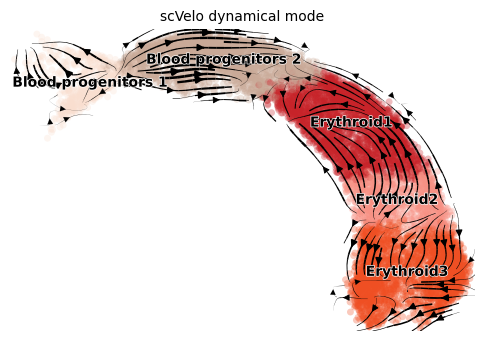

In [8]:
title = 'scVelo dynamical mode'
adata = scv.datasets.gastrulation_erythroid()
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

scv.tl.recover_dynamics(adata, n_jobs=20)
scv.tl.velocity(adata, mode='dynamical')

scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, color=label, dpi=100, title=title)

In [9]:
scv.pp.neighbors(adata)
adata_velo = adata[:, adata.var.loc[adata.var['velocity_genes'] == True].index]
exp_metrics["model_dyn"] = utv.evaluate(adata_velo, cluster_edges, label, 'velocity')

# Cross-Boundary Direction Correctness (A->B)
{('Blood progenitors 1', 'Blood progenitors 2'): -0.2417314949668877, ('Blood progenitors 2', 'Erythroid1'): -0.11234413583476499, ('Erythroid1', 'Erythroid2'): -0.7968808353191983, ('Erythroid2', 'Erythroid3'): -0.2568351816216074}
Total Mean: -0.35194791193561464
# In-cluster Coherence
{'Blood progenitors 1': 0.7927679910222623, 'Blood progenitors 2': 0.8114391255652827, 'Erythroid1': 0.8692230934014971, 'Erythroid2': 0.874011179638546, 'Erythroid3': 0.842684935958577}
Total Mean: 0.8380252651172331


Latent time is introduced based on transcriptional dynamics. It approximates the differentiated time experienced by cells.

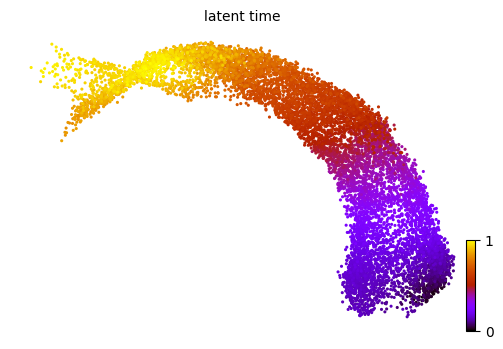

In [10]:
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=20, dpi=100)

## UniTVelo

Here we re-analysis the mouse gastrulation data subset to erythroid lineage. We demonstrate that UniTVelo with unified-time setting could alleviate the over-fitting problem.

UniTVelo requires a configuration file as input. You may sub-class it from base config file `config.py` and override the parameters you need to change (demonstrated below). For the details and comments of each parameter, please refer to `config.py`.

In [11]:
velo_config = utv.config.Configuration()
velo_config.R2_ADJUST = True
velo_config.IROOT = None
velo_config.FIT_OPTION = '1'

`utv.run_model` is an integrated function for RNA velocity analysis. It includes the core velocity estimation process and a few pre-processing functions provided by scVelo (normalization, neighbor graph construction to be specific).

-------> Model Configuration Settings <-------

 GPU: 2	FIG_DIR: ./figures/	BASE_FUNCTION: Gaussian	
 GENERAL: Curve	BASIS: None	N_TOP_GENES: 2000	
 OFFSET_GENES: False	FILTER_CELLS: False	EXAMINE_GENE: False	
 RESCALE_TIME: False	RESCALE_DATA: True	R2_ADJUST: True	
 IROOT: None	NUM_REPEAT: 1	FIT_OPTION: 1	
 DENSITY: SVD	REORDER_CELL: Soft_Reorder	AGGREGATE_T: True	
 ASSIGN_POS_U: False	WIN_SIZE: 50	LEARNING_RATE: 0.01	
 MAX_ITER: 10000	USE_RAW: False	RAW_GENES: False	

---> # of velocity genes used 513
---> # of velocity genes used 505
---> # of velocity genes used 503


  0%|          | 0/10000 [00:00<?, ?it/s]

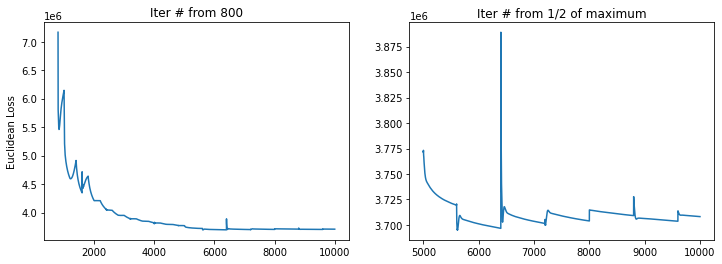

  0%|          | 0/9815 [00:00<?, ?cells/s]

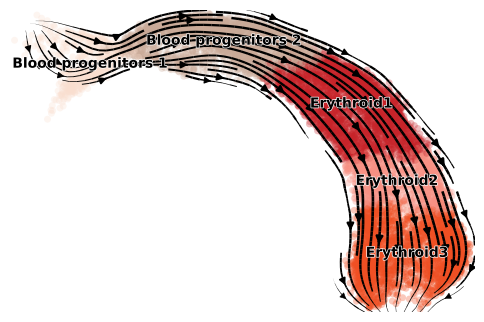

In [12]:
adata = utv.run_model('./data/Gastrulation/erythroid_lineage.h5ad', label, config_file=velo_config)
scv.pl.velocity_embedding_stream(adata, color=adata.uns['label'], dpi=100, title='')

Running UniTVelo may take a while depending on number of cells within beacuse currently the model adpots Gradient Descent for optimizing the loss function. Thus, returned data and fitted results for each gene are automatically saved under `tempdata` folder for future use.

In [13]:
import os
os.listdir('./data/Gastrulation/tempdata')

['Ms.csv', 'fitu.csv', 'Mu.csv', 'fits.csv', 'fitvar.csv', 'temp.h5ad']

Colors of each cluster can be changed manually if there is potential confusion on analysis.

In [27]:
adata = scv.read('./data/Gastrulation/tempdata/temp.h5ad')
adata.uns[f'{label}_colors'] = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c']

Evaluation metrics of UniTVelo illustrate the improved performance compare with previous method. Both CBDir and ICCoh value are higher.

In [15]:
scv.pp.neighbors(adata)
adata_velo = adata[:, adata.var.loc[adata.var['velocity_genes'] == True].index]
exp_metrics["model_unit"] = utv.evaluate(adata_velo, cluster_edges, label, 'velocity')

# Cross-Boundary Direction Correctness (A->B)
{('Blood progenitors 1', 'Blood progenitors 2'): 0.9072786593461084, ('Blood progenitors 2', 'Erythroid1'): 0.7650428018475586, ('Erythroid1', 'Erythroid2'): 0.8304018448051743, ('Erythroid2', 'Erythroid3'): 0.8277381954264528}
Total Mean: 0.8326153753563236
# In-cluster Coherence
{'Blood progenitors 1': 0.983277426107309, 'Blood progenitors 2': 0.9736145077846102, 'Erythroid1': 0.9904579975276204, 'Erythroid2': 0.9954329107426398, 'Erythroid3': 0.9962790431382197}
Total Mean: 0.9878123770600797


Similar results can also be observed using latent time.

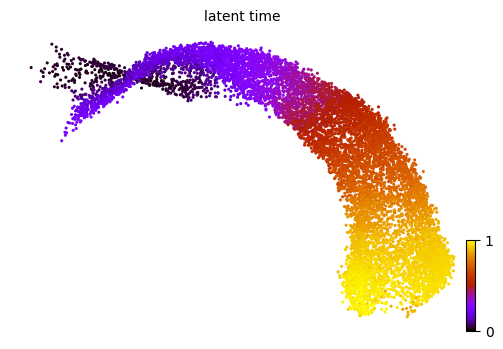

In [16]:
scv.tl.latent_time(adata, min_likelihood=None)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=20, dpi=100)

## Further Analysis

Both scVelo and UniTVelo undergo gene selction procedure before inferring veloctity matrix. Therefore, only a subset of genes have the inferred parameters.

In [29]:
subvar = adata.var.loc[adata.var['velocity_genes'] == True]
sub = adata[:, subvar.index]

UniTVelo is designed based on spiced mRNA oriented framework and currently a RBF model is used as linking function. The model has the ability to infer the activation time by scaling parameter, expression strength and peak time of individual genes. Specifically, by plotting the histogram of peak times, a brief activity of the biological system can be revealed. For instance, in this mouse erythroid lineage, most genes are classified as repression genes whilst a few are considered as induction genes. 

Text(0.5, 1.0, 'Peak Time')

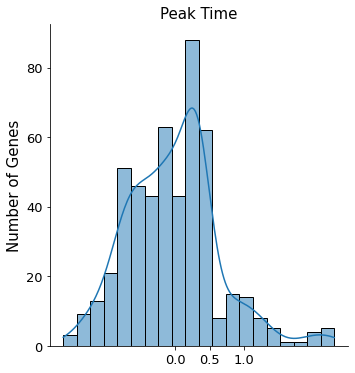

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(sub.var['fit_t0'].values, kde=True, bins=20)
plt.xticks([0, 0.5, 1], fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel('Number of Genes', fontsize=15)
plt.title('Peak Time', fontsize=15)

The phase portraits and transcriptional activities of each gene can be visualized by plotting function. For instance, `Cyr61`. It also supports the checking of un/spliced changes along time.

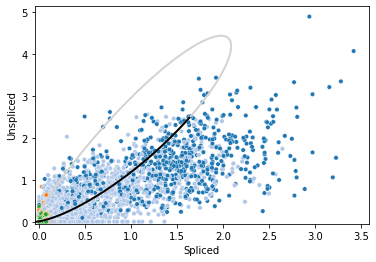

In [20]:
utv.pl.plot_range('Cyr61', adata, velo_config, show_legend=False, show_ax=True)

The following three heatmaps shows the expression profile (rows) againese cell ordering (columns, inferred cell time). Genes are separated into three groups for validation purpose, repression genes, inducitons genes and transient genes. Brighter color represents higher expression.

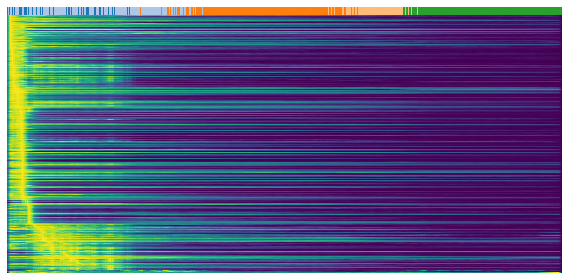

In [21]:
gene = sub.var.loc[sub.var['fit_t0'] < 0.05].index # repression gene
scv.pl.heatmap(
    adata, var_names=gene, sortby='latent_time', yticklabels=False,
    col_color='celltype', n_convolve=100)

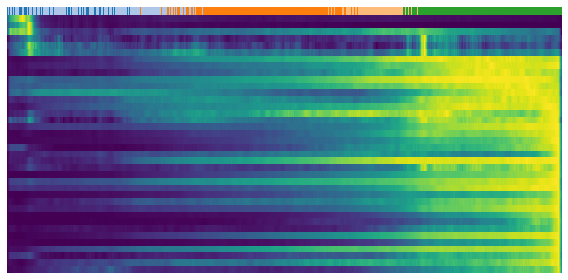

In [22]:
gene = sub.var.loc[sub.var['fit_t0'] > 0.95].index # induction gene
scv.pl.heatmap(
    adata, var_names=gene, sortby='latent_time', yticklabels=False,
    col_color='celltype', n_convolve=100)

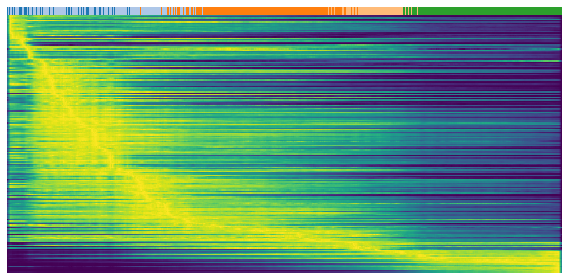

In [23]:
gene = sub.var.loc[(sub.var['fit_t0'] > 0.05) & (sub.var['fit_t0'] < 0.95)].index # transient gene
scv.pl.heatmap(
    adata, var_names=gene, sortby='latent_time', yticklabels=False,
    col_color='celltype', n_convolve=100)